In [1]:
import cv2
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [2]:
def bilinear_interpolation(image: np.array,scale_x:float,scale_y:float):
    old_height, old_width = image.shape
    M = int(scale_x * image.shape[0])
    N= int (scale_y*image.shape[1])
    row_scale = (old_height) / M
    col_scale = (old_width) / N
    
    resized_image = np.zeros((M, N), dtype=np.float32)

    for i in range(M):
        for j in range(N):
            i_old = i * row_scale
            j_old = j * col_scale
            
            x1 = int(np.floor(i_old))
            y1 = int(np.floor(j_old))
            x2 = min(x1 + 1, old_height - 1)
            y2 = min(y1 + 1, old_width - 1)
            
            f11 = image[x1, y1]
            f12 = image[x1, y2]
            f21 = image[x2, y1]
            f22 = image[x2, y2]
            
            d_i = i_old - x1
            d_j = j_old - y1
            
            linear1 = (1 - d_j) * f11 + d_j * f12
            linear2 = (1 - d_j) * f21 + d_j * f22
            
            resized_image[i, j] = (1 - d_i) * linear1 + d_i * linear2
    
    return resized_image
def gaussian_kernel_2D(size:int,sigma)->np.array:
    if(size % 2 ==0):
        raise("Enter odd value")
    x, y = np.meshgrid(np.arange(-(size//2), (size//2) + 1), np.arange(-(size//2), (size//2) + 1))
    kernel = np.exp( -0.5* (np.square(x) + np.square(y))/(np.square(sigma)))
    gaussian_kernel = kernel/np.sum(kernel)
    return gaussian_kernel
def blur_using_fft(image:np.array,kernel:np.array,intermediate=False)->np.array:
    image_shape = image.shape
    padded_image = np.pad(image,((image_shape[0]//2,image_shape[0]//2),(image_shape[1]//2,image_shape[1]//2)),mode='reflect')
    padded_kernel = np.zeros(padded_image.shape)
    padded_kernel[(padded_kernel.shape[0] // 2 - kernel.shape[0] // 2):(padded_kernel.shape[0] // 2 + kernel.shape[0] // 2 + 1), 
                  (padded_kernel.shape[1] // 2 - kernel.shape[1] // 2):(padded_kernel.shape[1] // 2 + kernel.shape[1] // 2 + 1)] = kernel
    padded_kernel = fftshift(padded_kernel)
    F_image = fft2(padded_image)
    F_kernel = fft2(padded_kernel)
    Image_filtered = F_image*F_kernel
    inversed = np.real(ifft2(Image_filtered))
    x,y = image_shape[0]//2,image_shape[1]//2
    out_image =inversed[x:x+image_shape[0],y:y+image_shape[1]]
    out_image =((out_image - np.min(out_image))/(np.max(out_image)-np.min(out_image)) *255).astype(np.uint8)
    return out_image.astype(np.uint8)

In [3]:
def notch_reject_filter_frequency(rows,cols, u, v, D0=10):
    u_shift = np.arange(cols) - cols//2
    v_shift = np.arange(rows) - rows//2
    X,Y = np.meshgrid(u_shift,v_shift)
    D_u_v = np.sqrt((X - u)**2 + (Y - v)**2)
    H = 1 - np.exp(-(D_u_v**2) / (2 * (D0**2)))
    return H

In [4]:
image_1 = cv2.imread("data/Q2_image1.png",cv2.IMREAD_ANYDEPTH)
if image_1.ndim == 3 and image_1.shape[-1] == 1:
    image_1 = image_1.squeeze(-1) 

In [5]:
scaling_x = 0.2
scaling_y = 0.2
sigma_x = 0.5+(scaling_x/np.pi)
sigma_y = 0.5+(scaling_y/np.pi)

aliased_image = bilinear_interpolation(image_1,scaling_x,scaling_y)
cv2.imwrite("output_images/Q2/alised_image.png",aliased_image,[cv2.IMWRITE_PNG_COMPRESSION,0])

True

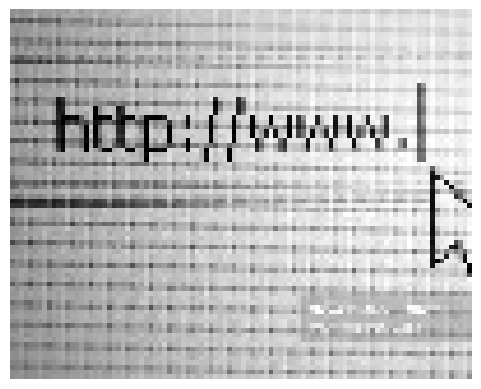

In [6]:
plt.imshow(aliased_image, cmap='gray')
plt.axis('off')
plt.show()


In [7]:
kernel = gaussian_kernel_2D(5,np.maximum(sigma_x,sigma_y))
filtered_image = blur_using_fft(image_1,kernel)
cv2.imwrite("output_images/Q2/filtered_image_spatial.png",filtered_image,[cv2.IMWRITE_PNG_COMPRESSION,0])
rescaled_image_after_filter = bilinear_interpolation(filtered_image,scaling_x,scaling_y)
cv2.imwrite("output_images/Q2/rescaled_image_after_filter.png",rescaled_image_after_filter,[cv2.IMWRITE_PNG_COMPRESSION,0])

True

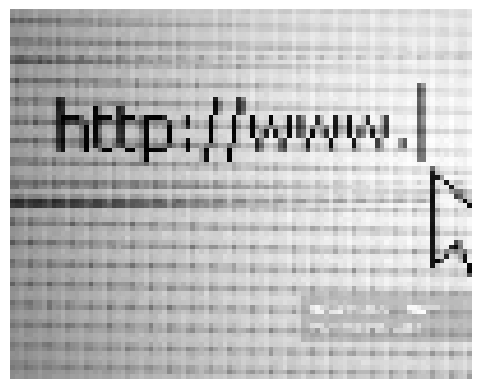

In [8]:
plt.imshow(rescaled_image_after_filter, cmap='gray')
plt.axis('off')
plt.show()


In [9]:
# image_1 = cv2.imread("data/myimage.jpg",cv2.IMREAD_ANYDEPTH)
# cv2.imwrite("data/Q2_image1.png",image_1)
# f_tranform = fft2(image_1)


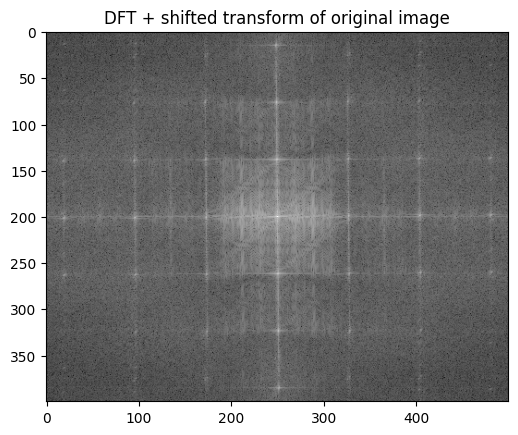

In [10]:
#************************************************************************Part C***************************************
# Part c
f_tranform = fft2(image_1)
shifted_transform = fftshift(f_tranform)
spectrum = np.log(np.abs(shifted_transform))
spectrum_display = 255*(spectrum -np.min(spectrum)/np.max(spectrum) - np.min(spectrum))
plt.imshow(spectrum_display, cmap='gray')
plt.axis('on')
plt.title("DFT + shifted transform of original image")
plt.savefig("output_images/Q2/shifted_tranform_image.png")
plt.show()

In [11]:
# spectrum_without_shift = np.log(np.abs(f_tranform))
# spectrum_display_without_shift = 255*(spectrum_without_shift -np.min(spectrum_without_shift)/np.max(spectrum_without_shift) - np.min(spectrum_without_shift))
# plt.imshow(spectrum_display_without_shift, cmap='gray')
# plt.axis('off')
# plt.title("DFT + shifted transform of original image")
# plt.savefig("output_images/Q2/shifted_tranform_image.png")
# plt.show()

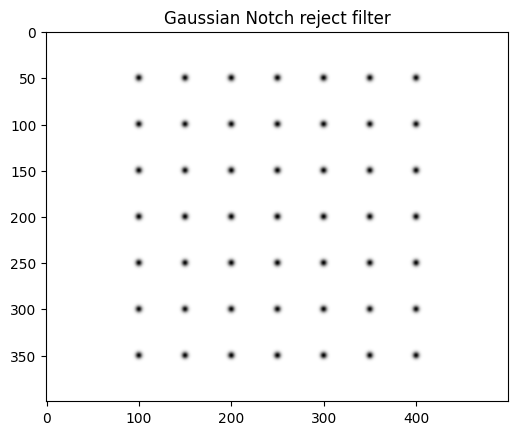

In [12]:
 

f_tranform = fft2(image_1)

spike_x = []
spike_y =[]
start_x = 50
start_y =  100
H = np.ones(f_tranform.shape)
for i in range(7):
    spike_x.append(start_x)
    spike_y.append(start_y)
    start_y += 50
    start_x += 50

def gaussian_notch(H, center, D0):
    cx, cy = center
    for u in range(H.shape[0]):
        for v in range(H.shape[1]):
            distance = (u - cx)**2 + (v - cy)**2
            H[u, v] *= 1 - np.exp(-distance / (2 * D0**2))
    return H

D0 = 1/(2*scaling_x)
for x in spike_x:
    for y in spike_y:
     H = gaussian_notch(H, (x, y), D0)
plt.imshow(H, cmap='gray')
plt.title('Gaussian Notch reject filter')
plt.savefig("output_images/Q2/gaussian_notch_reject filter.png")
plt.show()


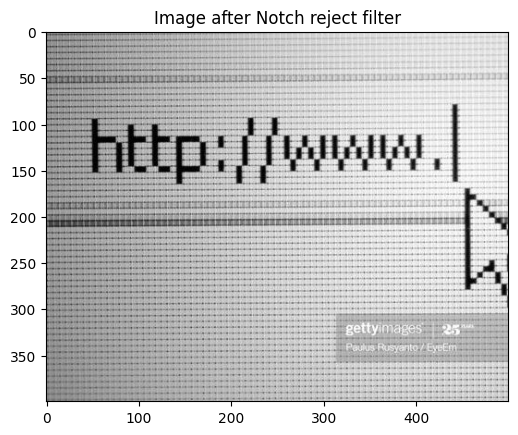

In [13]:
G = f_tranform* H
g_filtered = np.abs(ifft2(ifftshift(G)))
plt.imshow(g_filtered, cmap='gray')
plt.title('Image after Notch reject filter')
plt.savefig("output_images/Q2/image_filtered_with_notch reject filter.png")

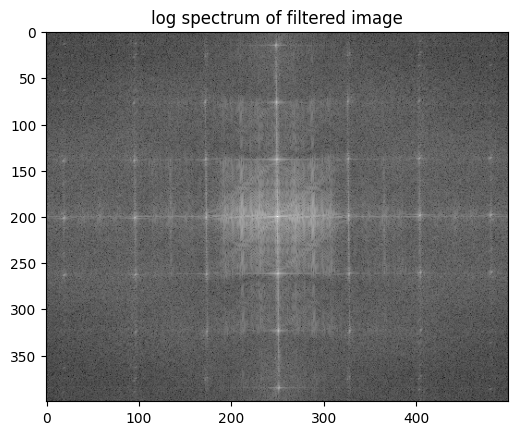

In [14]:
spectrum_filtered = np.log(np.abs(shifted_transform))
# spectrum_filtered = np.abs(shifted_transform)

spectrum_filtered_display = 255*(spectrum_filtered -np.min(spectrum_filtered)/np.max(spectrum_filtered) - np.min(spectrum_filtered))
plt.imshow(spectrum_filtered_display, cmap='gray')
plt.title('log spectrum of filtered image')
plt.savefig("output_images/Q2/filtered image spectrum.png")

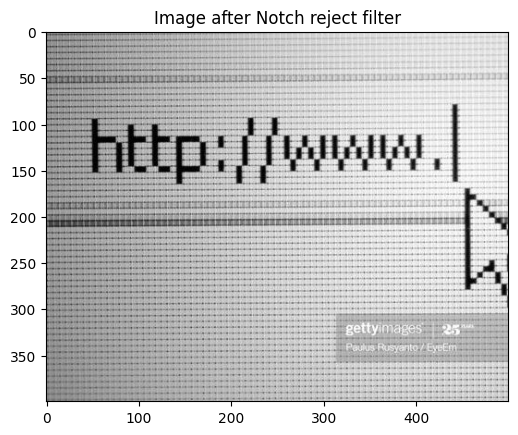

In [15]:
plt.imshow(g_filtered, cmap='gray')
plt.title('Image after Notch reject filter')
plt.savefig("output_images/Q2/image_filtered_with_notch reject filter.png")
plt.show()

In [16]:
#*******************Part D************************
#Optimum notch filter
print("*************part D***************")

*************part D***************


In [17]:

def sliding_window_horizontal(img, n):
    M, N = img.shape
    window_sum = np.zeros_like(img)
    window_sum[:, 0] = np.sum(img[:, :n], axis=1)
    for j in range(1, N - n + 1):
        window_sum[:, j] = window_sum[:, j-1] - img[:, j-1] + img[:, j+n-1]
    return window_sum
def sliding_window_vertical(img, m):
    M, N = img.shape
    window_sum = np.zeros_like(img)
    window_sum[0, :] = np.sum(img[:m, :], axis=0)
    for i in range(1, M - m + 1):
        window_sum[i, :] = window_sum[i-1, :] - img[i-1, :] + img[i+m-1, :]
    return window_sum

def compute_mean_variance(img, m, n):
    horizontal_sum = sliding_window_horizontal(img, n)
    window_sum = sliding_window_vertical(horizontal_sum, m)
    window_area = m * n
    mean_f = window_sum / window_area

    horizontal_sum_f2 = sliding_window_horizontal(img**2, n)
    window_sum_f2 = sliding_window_vertical(horizontal_sum_f2, m)
    mean_f2 = window_sum_f2 / window_area
    variance_f = mean_f2 - mean_f*mean_f
    return mean_f, variance_f

def compute_covariance(f, eta, m, n):
    mean_f, _ = compute_mean_variance(f, m, n)
    mean_eta, _ = compute_mean_variance(eta, m, n)
    mean_f_eta, _ = compute_mean_variance(f * eta, m, n)
    covariance = mean_f_eta - mean_f * mean_eta
    return covariance

def compute_weight_covariance(f, eta, variance_eta, m, n):
    covariance_f_eta = compute_covariance(f, eta, m, n)
    return covariance_f_eta / (variance_eta +1e-10)



In [18]:
m=16
n=16
padded_image = np.pad(image_1,16)
_,S_xy = compute_mean_variance(padded_image,m,n)
print("padded_image_shape :",padded_image.shape," original image shape :",image_1.shape)
S_xy = S_xy[16:16+image_1.shape[0],16:16+image_1.shape[1]]

padded_image_shape : (432, 532)  original image shape : (400, 500)


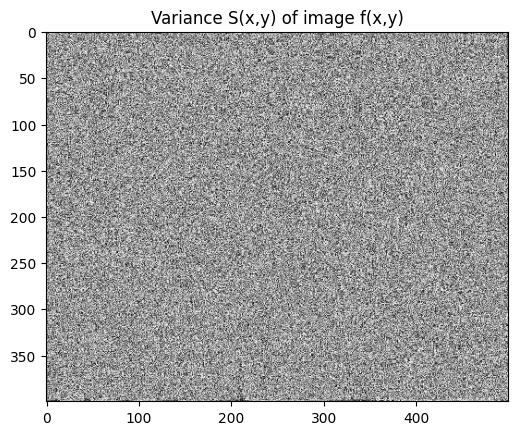

In [19]:
S_xy =255*(S_xy - np.min(S_xy))/(np.max(S_xy) - np.min(S_xy))
plt.imshow(S_xy, cmap='gray')
plt.title('Variance S(x,y) of image f(x,y)')
plt.savefig("output_images/Q2/variance_image.png")
plt.show()

In [20]:
#######*****************Part E ****************
print("********************Part E*****************")
m=16
n=16
H = fftshift(H)
eta = np.abs(ifft2(H))
f_hat = g_filtered   #filtered image
eta_padded = np.pad(eta,16)
f_hat_padded = np.pad(f_hat,16)

********************Part E*****************


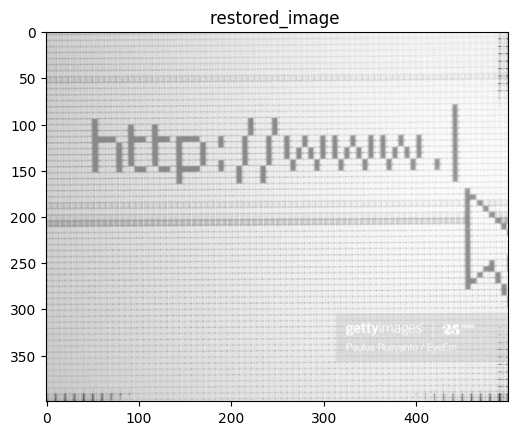

In [21]:
mean_f, variance_f = compute_mean_variance(f_hat_padded, m, n)

mean_eta, variance_eta = compute_mean_variance(eta_padded, m, n)
w = compute_weight_covariance(f_hat_padded, eta_padded, variance_eta, m, n)
w = w[16:16+f_hat.shape[0],16:16+f_hat.shape[1]]
 
restored_image = f_hat - w*eta

restored_image_normalized = 255 * (restored_image - np.min(restored_image)) / (np.max(restored_image) - np.min(restored_image))
restored_image_normalized = restored_image_normalized.astype(np.uint8)

plt.imshow(restored_image_normalized, cmap='gray')
plt.title('restored_image ')
plt.savefig("output_images/Q2/restored_image.png")
plt.show()


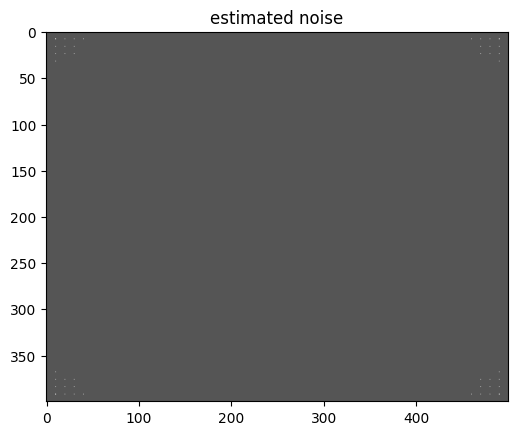

In [22]:
eta_show = (255*(eta -np.min(eta))/(np.max(eta) - np.min(eta))).astype(np.int8)
plt.imshow(eta_show, cmap='gray')
plt.title('estimated noise')
plt.savefig("output_images/Q2/noise.png")
plt.show()

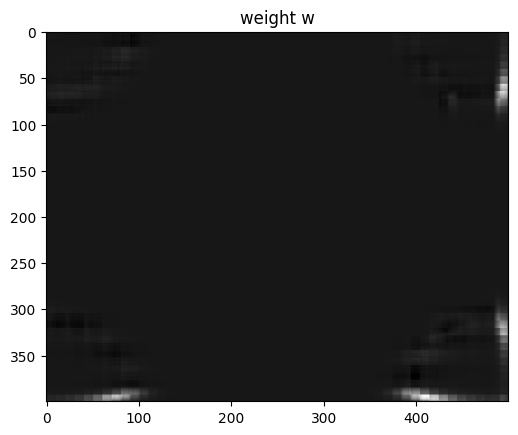

In [23]:
w_show = (255*(w -np.min(w))/(np.max(w) - np.min(w))).astype(np.int8)
plt.imshow(w, cmap='gray')
plt.title('weight w')
plt.savefig("output_images/Q2/weight.png")
plt.show()

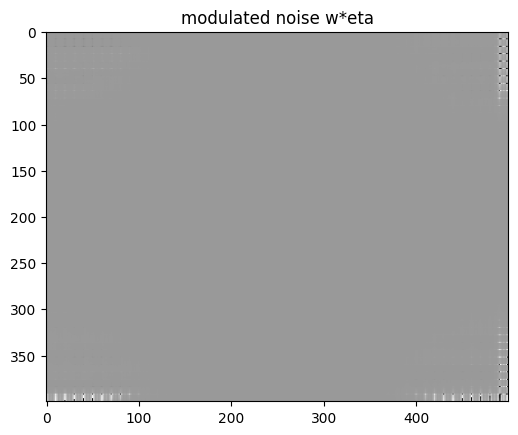

In [24]:
modulated_noise = w*eta
modulated_noise_show = (255*(modulated_noise -np.min(modulated_noise))/(np.max(modulated_noise) - np.min(modulated_noise))).astype(np.int8)
plt.imshow(modulated_noise_show, cmap='gray')
plt.title('modulated noise w*eta')
plt.savefig("output_images/Q2/modulated_noise.png")
plt.show()